# SniffNets

This notebook contains the implementation of the SniffNets models created for clasifying the codification of signals deteced from artificial noses. The experiments in this notebook were used in the article [Deep learning models for classification of gases detected by sensor arrays of artificial nose](https://sol.sbc.org.br/index.php/eniac/article/view/9339).

Where the data features is divided in sliding windows, which is a rapid detection technique stated in the article [Wine quality rapid detection using a compact electronic nose system: application focused on
spoilage thresholds by acetic acid](https://arxiv.org/pdf/2001.06323.pdf)

* Disclaimer: Unfortunately the Coffee dataset is not publicly available.

## Run the following code if you are using google colab

In [ ]:
# Run this block it you are using google colaboratory and desire to save the results in
# google drive
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# Run this block it you are using google colaboratory
!git clone https://github.com/IsmaelCesar/SniffNets.git

In [ ]:
import os
import sys
sys.path.append("SniffNets/")
import data_loading
data_loading.DATA_FOLDER = os.path.join("SniffNets/",data_loading.DATA_FOLDER)

## Defining and running experiments

In [6]:
import time
from sklearn.utils import shuffle
from data_loading import load_dataset, split_datasamples_by_sensors, standardize_data
from data_loading import dataset_classes_number, dataset_wine_classes_number
from experiment_procedures import resettv, get_dataset_names_and_indexes, get_wine_dataset_names_and_indexes
from models import sniffnet, sniffresnet, sniffmultinose
from evaluation import evaluate_model_windows, save_results_into_filesystem_windows
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.utils import to_categorical

## Running Models

### Defining experiments parameters

In [3]:
batch_size = 10
epochs = 1
lr = .001
parameters = resettv()

# Experiment results to be saved
experiment_folder = "put the directory here"
save_results = False
time_estimate_list_titles = [["model type",
                              "datset and sub dataset name",
                              "total_execution_time",
                              "windows_processed"]]

### Deffining auxiliary procedures

In [4]:
def run_windowed_experiment(batch_size, epochs, lr, parameters, 
                            save_results=True, read_wine=False):
    global experiment_folder
    list_of_keys = list(parameters.keys())

    if read_wine:
        # Creating indexes for each dataset being loaded
        names_list = list(get_wine_dataset_names_and_indexes().keys())
    else: 
        datasets_names = get_dataset_names_and_indexes()

    names_list = list(datasets_names.keys())
    
    # Taking the parameters for fonollosa dataset as a test case
    # Iterating over model type, where the all the model types created are the normal ConvNet, Resnet an FusionNEt
    # Where for the fusion net the data needs a special treatment
    # models_names = ["SniffConvNet", "SniffResnet", "SniffMultinose"]
    models_names = [(0, "SniffConvNet"), (1, "SniffResnet"), (2, "SniffMultinose")]
    
    
    for (model_type, m_name) in models_names:
        print("\n\tUsin " + m_name + " architechture\n")
        model_folder = m_name + "/"
        # Interating over dataset names
        for i, name in enumerate(names_list):
            print("\n\tDataset " + name + "\n")
            sub_set_index = datasets_names[name]
            # Iterating over subset indexes
            for ss_idx in sub_set_index:
                print("\n\n ds_name:"+name+"\n\n")
                print("\n\n ds_idx:"+str(ss_idx)+"\n\n")
                f_params = parameters[name]
                # Load dataset
                (data, labels, n_classes,
                 dataset_name, sub_dataset_name, input_shape) = load_dataset(name, ss_idx,
                                                                             read_wine_datasets=read_wine)
                time_estimate_list = []
                toc = time.time()
                n_windows_processed = 0
                data, labels = shuffle(data, labels)
                for final_measurement in range(f_params['start_value'], f_params['end_value'], f_params['step']):
                    print("\n\n\t Window", final_measurement)
                    print("\n\n")
                    print("\n\tSubset " + sub_dataset_name + "\n")
                    train_data, test_data, train_labels, test_labels = train_test_split(
                        data[:, f_params['ini_value']:final_measurement, :],
                        labels, test_size=0.2)
                    # Normalizing data
                    train_data, test_data = standardize_data(train_data, test_data, test_data.shape[1:])

                    train_labels = to_categorical(train_labels, n_classes)
                    test_labels = to_categorical(test_labels, n_classes)

                    if model_type == 2:
                        # Reshapes data if usign the SniffMultinose
                        train_data = data_set_reshaped(train_data)
                        test_data = data_set_reshaped(test_data)
                        input_shape = train_data[0].shape
                        train_data = split_datasamples_by_sensors(train_data)
                        test_data = split_datasamples_by_sensors(test_data)

                    # defining model
                    model = None
                    if model_type == 0:
                        model = sniffnet(train_data.shape[1:], n_classes)
                    elif model_type == 1:
                        model = sniffresnet(train_data.shape[1:], n_classes)
                    elif model_type == 2:
                        model = sniffmultinose(input_shape, n_classes)
                    elif model_type == 3:
                        model = get_svm()
                    print("Model " + m_name + " has been created")

                    model.compile(loss="categorical_crossentropy",
                                  optimizer= SGD(lr=lr, momentum=.9),
                                  metrics=['accuracy'])
                    H = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, verbose=1,
                                  validation_data=(test_data, test_labels))

                    n_windows_processed += 1
                    
                    evaluate_model_windows(test_data, test_labels, batch_size, model, epochs, H, 
                                           experiment_folder, dataset_name, sub_dataset_name, model_folder,
                                           window_size=str(final_measurement), save_results=save_results)
                    
                tic = time.time()
                time_estimate_set_names = name+" "+sub_dataset_name
                total_estimate = tic - toc
                time_estimate_list.append([m_name,time_estimate_set_names,
                                           total_estimate, 
                                           n_windows_processed])
                if save_results: 
                    write_csv(experiment_folder,"time_estimates_wt_fon_tgm_coff.csv",
                              time_estimate_list,
                              mode='a+')

### Runnig experiments for Fonollosa, Windtunnel and Turbulent Gas Mixtures datasets


	Usin SniffResnet architechture


	Dataset fonollosa



 ds_name:fonollosa




 ds_idx:0




 ds_name:fonollosa




 ds_idx0




	 Window 1280




	Subset B1-system/

Model SniffResnet has been created
13/13 [==============================] - 4s 343ms/step - loss: nan - accuracy: 0.2344 - val_loss: nan - val_accuracy: 0.2500
[INFO] Evaluating Network


KeyError: 'acc'

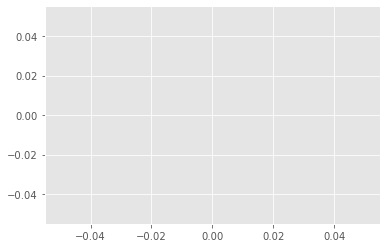

In [7]:
if save_results:
    write_csv(experiment_folder,"time_estimates_wt_fon_tgm.csv", time_estimate_list_titles)

run_windowed_experiment(batch_size, epochs, lr, parameters, save_results=save_results)

### Running experiments for the Wine dataset 

In [ ]:
if save_results:
    write_csv(experiment_folder,"time_estimates_wt_fon_tgm.csv", time_estimate_list_titles)

run_windowed_experiment(batch_size, epochs, lr, parameters, save_results=save_results, read_wine=True)